# Source Code

In [1]:
import tensorflow as tf
import os
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

## Load Data

In [2]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
print('User 의 수:', data['UserId'].nunique())
print('Item 의 수:', data['ItemId'].nunique())

User 의 수: 6040
Item 의 수: 3706


## Data Preprocess

### Rating 이 3 미만인 데이터 제거

- rating 이 3 미만인 경우, 유저가 해당 영화를 선호하지 않는다고 판단하여 제거해주었습니다.

In [5]:
data = data[data['Rating'] >= 3]

In [6]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [7]:
print('User 의 수:', data['UserId'].nunique())
print('Item 의 수:', data['ItemId'].nunique())

User 의 수: 6039
Item 의 수: 3628


### User 별 평가한 영화 수 확인

In [8]:
user_length = data.groupby('UserId').size()

print('user_length 중앙값:', user_length.median())
print('user_length 평균값:', user_length.mean())
print('user_length 최소값:', user_length.min())
print('user_length 최대값:', user_length.max())
print('user_length 99.9%:', user_length.quantile(0.999))

user_length 중앙값: 81.0
user_length 평균값: 138.51266766020865
user_length 최소값: 1
user_length 최대값: 1968
user_length 99.9%: 1118.8860000000013


- User 별 평가한 영화는 평균 138 개입니다.
<br>
<br>
- 최대는 1968 개이며, 99.9% 의 User 가 약 1119 개 이내로 평가하였습니다.
<br>
<br>
- 가장 많은 영화를 평가한 User 데이터를 살펴보겠습니다.

In [9]:
user_outlier = user_length[user_length == 1968].index[0]
data[data['UserId'] == user_outlier]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697055,4169,3207,3,1024172606
695958,4169,3413,3,1024173191
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760


- 같은 시간에 여러 개의 영화를 평가한 기록이 보입니다.
<br>
<br>
- 이는, 과거에 본 여러 영화들을 추후에 한번에 평가했을 가능성이 존재하므로 제거하지 않도록 하겠습니다.

In [10]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1029    0.998013
1034    0.998344
1054    0.998510
1106    0.998675
1116    0.998841
Length: 636, dtype: float64

Text(0.5, 1.0, 'Cumsum Percentage Until 0.999')

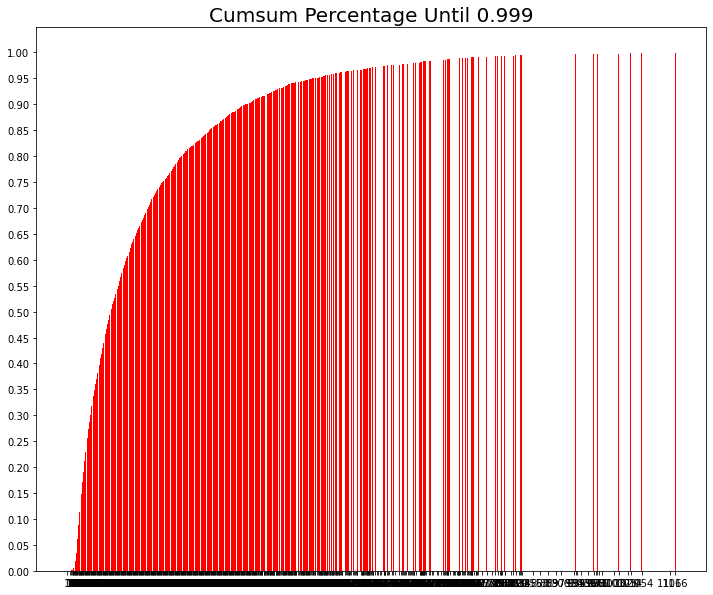

In [11]:
plt.figure(figsize = (12, 10))
plt.bar(x = length_percent_cumsum_999.index,
        height = length_percent_cumsum_999, color = 'red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)

### 시간 관련 정보 확인

In [12]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')

data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()

oldest, latest

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

- 약 3 년치의 데이터가 있습니다.

### Data Cleansing

In [14]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_watch) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_watch)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

In [15]:
def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data

In [16]:
def cleanse_unpopular_item(data: pd.DataFrame, least_watch):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_watch].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
data = cleanse_recursive(data, shortest = 2, least_watch = 5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- 최소한 두 편 이상의 영화를 시청한 유저와,
<br>
<br>
- 최소한 다섯 번 이상 시청된 영화를 학습에 사용하도록 하겠습니다.

### Train / Valid / Test Split

In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]

    return user_in_train, user_in_test

In [19]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [20]:
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

In [21]:
tr, test = split_by_date(data, 180)
tr, val = split_by_date(tr, 180)

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 818736
	 Users: 6036
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9771
	 Users: 390
	 Items: 2348
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7282
	 Users: 333
	 Items: 2049
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



- valid 와 test 데이터를 각각 6개월치의 데이터로 나누어주었습니다.

In [23]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- train set 을 기준으로 item 을 인덱싱해주었습니다.

In [24]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pipeline

### Session Dataset

In [25]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.user_offsets = self.get_user_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())

    def get_user_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        
        return offsets

In [26]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


- user_offsets 에는 User 의 시작 인덱스가 담겨있습니다.
<br>
<br>
- user_idx 에는 User 의 인덱스 정보가 담겨있습니다.

In [27]:
tr_dataset.user_offsets

array([     0,     53,    169, ..., 818341, 818460, 818736], dtype=int32)

In [28]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

### Session Data Loader

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_session = self.batch_size - 1
        start = self.dataset.user_offsets[self.dataset.user_idx[first_iters]]
        end = self.dataset.user_offsets[self.dataset.user_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session > self.dataset.user_idx[-1]:
                finished = True
                break

            start[idx] = self.dataset.user_offsets[self.dataset.user_idx[new_session]]
            end[idx] = self.dataset.user_offsets[self.dataset.user_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Modeling

### Evaluation Metric

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [33]:
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    
    return model

In [42]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [43]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    503850    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [44]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

In [45]:
def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)

In [46]:
def get_metrics(data, model, args, k: int): 
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [47]:
train_model(model, args)

Evaluation:  14%|█▍        | 5/36 [00:05<00:36,  1.18s/it]


	 - Recall@20 epoch 1: 0.057031
	 - MRR@20    epoch 1: 0.013888



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.06s/it]


	 - Recall@20 epoch 2: 0.092969
	 - MRR@20    epoch 2: 0.026239



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


	 - Recall@20 epoch 3: 0.099219
	 - MRR@20    epoch 3: 0.029388



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


	 - Recall@20 epoch 4: 0.110156
	 - MRR@20    epoch 4: 0.033369



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


	 - Recall@20 epoch 5: 0.114844
	 - MRR@20    epoch 5: 0.034923



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.07s/it]


	 - Recall@20 epoch 6: 0.121094
	 - MRR@20    epoch 6: 0.037148



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.06s/it]


	 - Recall@20 epoch 7: 0.119531
	 - MRR@20    epoch 7: 0.037954



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.04s/it]


	 - Recall@20 epoch 8: 0.118750
	 - MRR@20    epoch 8: 0.037887



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.05s/it]


	 - Recall@20 epoch 9: 0.120313
	 - MRR@20    epoch 9: 0.039468



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.06s/it]

	 - Recall@20 epoch 10: 0.119531
	 - MRR@20    epoch 10: 0.039182



- Recall 과 MRR 이 미세하게 증가하였음을 확인할 수 있습니다.

## Modeling_2

### Model Architecture_2

In [49]:
args_2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model_2 = create_model(args_2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


### Model Training_2

In [50]:
train_model(model_2, args_2)

Evaluation:  47%|████▋     | 34/73 [00:19<00:22,  1.75it/s]


	 - Recall@20 epoch 1: 0.093290
	 - MRR@20    epoch 1: 0.021959



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]


	 - Recall@20 epoch 2: 0.119256
	 - MRR@20    epoch 2: 0.034342



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 3: 0.124770
	 - MRR@20    epoch 3: 0.036052



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.81it/s]


	 - Recall@20 epoch 4: 0.127298
	 - MRR@20    epoch 4: 0.037768



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 5: 0.128217
	 - MRR@20    epoch 5: 0.038715



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.83it/s]


	 - Recall@20 epoch 6: 0.132583
	 - MRR@20    epoch 6: 0.039073



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 7: 0.133502
	 - MRR@20    epoch 7: 0.039221



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 8: 0.139017
	 - MRR@20    epoch 8: 0.039652



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 9: 0.136949
	 - MRR@20    epoch 9: 0.039125



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]

	 - Recall@20 epoch 10: 0.137868
	 - MRR@20    epoch 10: 0.039922



- 이전 Model 보다 비교적 더 빠르게 Recall 과 MRR 이 증가하였음을 확인할 수 있습니다.

## Modeling_3

### Model Architecture_3

In [51]:
args_3 = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model_3 = create_model(args_3)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1022700   
_________________________________________________________________
dropout_4 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_4 (Dense)              (128, 3307)               334007    
Total params: 1,356,707
Trainable params: 1,356,707
Non-trainable params: 0
_________________________________________________________________


### Model Training_3

In [52]:
train_model(model_3, args_3)

Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.80it/s]


	 - Recall@20 epoch 1: 0.110524
	 - MRR@20    epoch 1: 0.031467



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]


	 - Recall@20 epoch 2: 0.125689
	 - MRR@20    epoch 2: 0.034387



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.85it/s]


	 - Recall@20 epoch 3: 0.133961
	 - MRR@20    epoch 3: 0.036903



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 4: 0.134881
	 - MRR@20    epoch 4: 0.037734



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.85it/s]


	 - Recall@20 epoch 5: 0.137178
	 - MRR@20    epoch 5: 0.037533



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.85it/s]


	 - Recall@20 epoch 6: 0.137178
	 - MRR@20    epoch 6: 0.038393



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.85it/s]


	 - Recall@20 epoch 7: 0.138097
	 - MRR@20    epoch 7: 0.038922



Evaluation:  47%|████▋     | 34/73 [00:18<00:20,  1.86it/s]


	 - Recall@20 epoch 8: 0.137408
	 - MRR@20    epoch 8: 0.038635



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.85it/s]


	 - Recall@20 epoch 9: 0.139706
	 - MRR@20    epoch 9: 0.038986



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.83it/s]

	 - Recall@20 epoch 10: 0.138097
	 - MRR@20    epoch 10: 0.038959



- model_2 와 비교하였을 때 최종 Recall 과 MRR 은 유의미한 차이를 보이지 않았으나, 더욱 빠르게 증가하고 있는 모습을 확인할 수 있습니다.

## Modeling_4

### Model Architecture_4

In [53]:
args_4 = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.2, lr=0.001, epochs=10, k=20)
model_4 = create_model(args_4)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1022700   
_________________________________________________________________
dropout_5 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_5 (Dense)              (128, 3307)               334007    
Total params: 1,356,707
Trainable params: 1,356,707
Non-trainable params: 0
_________________________________________________________________


### Model Training_4

In [54]:
train_model(model_4, args_4)

Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.80it/s]


	 - Recall@20 epoch 1: 0.108456
	 - MRR@20    epoch 1: 0.028901



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]


	 - Recall@20 epoch 2: 0.126838
	 - MRR@20    epoch 2: 0.035764



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]


	 - Recall@20 epoch 3: 0.127987
	 - MRR@20    epoch 3: 0.037409



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 4: 0.136259
	 - MRR@20    epoch 4: 0.038233



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.85it/s]


	 - Recall@20 epoch 5: 0.137408
	 - MRR@20    epoch 5: 0.039128



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]


	 - Recall@20 epoch 6: 0.136949
	 - MRR@20    epoch 6: 0.039966



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.83it/s]


	 - Recall@20 epoch 7: 0.137868
	 - MRR@20    epoch 7: 0.041026



Evaluation:  47%|████▋     | 34/73 [00:18<00:20,  1.86it/s]


	 - Recall@20 epoch 8: 0.140855
	 - MRR@20    epoch 8: 0.039994



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 9: 0.139936
	 - MRR@20    epoch 9: 0.040582



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.80it/s]

	 - Recall@20 epoch 10: 0.141085
	 - MRR@20    epoch 10: 0.039752



- 4 개의 모델 중 가장 높은 Recall 과 MRR 이 도출되었습니다.

## Inference

In [56]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### Model_1

- batch_size = 256
- hsz = 50
- drop_rate = 0.1
- lr = 0.001

In [57]:
test_model(model, args, test)

Evaluation:   7%|▋         | 2/27 [00:02<00:26,  1.07s/it]

	 - Recall@20: 0.121094
	 - MRR@20: 0.042064



### Model_2

- batch_size = 128
- hsz = 50
- drop_rate = 0.1
- lr = 0.001

In [58]:
test_model(model_2, args_2, test)

Evaluation:  37%|███▋      | 20/54 [00:11<00:18,  1.80it/s]

	 - Recall@20: 0.149219
	 - MRR@20: 0.043556



### Model_3

- batch_size = 128
- hsz = 100
- drop_rate = 0.1
- lr = 0.001

In [59]:
test_model(model_3, args_3, test)

Evaluation:  37%|███▋      | 20/54 [00:10<00:18,  1.84it/s]

	 - Recall@20: 0.152344
	 - MRR@20: 0.045058



### Model_4

- batch_size = 128
- hsz = 100
- drop_rate = 0.2
- lr = 0.001

In [60]:
test_model(model_4, args_4, test)

Evaluation:  37%|███▋      | 20/54 [00:11<00:18,  1.81it/s]

	 - Recall@20: 0.157812
	 - MRR@20: 0.045053



## Summary

- 하이퍼 파라미터를 변경한 네 가지의 모델로 성능을 평가하였습니다.
<br>
<br>
- Model_1 에서는 Recall 과 MRR 이 각각 0.121094, 0.042064 로 측정되었습니다.
<br>
<br>
- Model_2 에서는 batch_size 를 128 로 줄이자 Recall 이 0.149219, MRR 이 0.043556 로 다소 증가하였습니다.
<br>
<br>
- Model_3 에서는 batch_size 를 128 로 유지하고 GRU 의 파라미터인 hsz 를 100 으로 늘려주었습니다. 최종적으로 Recall 이 0.152344, MRR 이 0.045058 로 증가한 것을 확인할 수 있습니다.
<br>
<br>
- Model_4 에서는 batch_size 를 128, hsz 를 100 으로 유지하고 drop_rate 를 0.2 로 늘려주었습니다. 최종적으로 Recall 이 0.157812, MRR 이 0.045053 로 증가하였습니다.
<br>
<br>
- 결론적으로 batch_size 를 줄이고 hsz 와 drop_rate 를 늘려준 Model_4 의 Recall, MRR 이 가장 높게 측정되었습니다.

# Retrospection

<h2 style="font-style:italic">2022.03.14 - [E-16]Session_based_Recommendation_Movielens</h2>

> 이번 프로젝트에서는 Movielens 데이터셋을 활용하여 Session based Recommendation System 을 구현해보았습니다.
***

- 이번 프로젝트에서는 Movielens 데이터셋의 UserId 컬럼을 SessionId 로 설정하여 이를 기반으로 한 학습 및 예측을 수행하였다.
<br>
<br>
- 하지만, UserId 와 Time 컬럼을 모두 활용하여 SessionId 로 활용할 수도 있었을 것이라는 생각이 들었다. Session 의 특성과는 달리, 동일한 UserId 의 모든 Time 은 같은 유저가 남긴 기록이기 때문이다.
<br>
<br>
- 처음 접해본 GRU 모델이니만큼, 다양한 하이퍼 파라미터를 자유자재로 다루는 것에 있어 익숙치 않았다.
<br>
<br>
- GRU 모델의 Layer 혹은 하이퍼 파라미터에 대한 기반 지식이 있었다면 비교적 자유로운 하이퍼 파라미터 세팅으로 조금 더 높은 성능을 기대해볼 수 있을 것으로 사료된다.
<br>
<br>
- 또한 이번 프로젝트에서는 Rating 이 3 미만인 데이터에 대해 제거하고 학습을 수행하였지만, 모든 Rating 에 대해 학습을 수행하였을 때의 성능 측정도 유의미한 시도일 것이라고 생각한다. 하지만 성능 향상에 있어 긍정적인 영향을 미칠 것이라고 기대되지는 않는다.
<br>
<br>
- 5 번 이하로 시청된 영화는 제거되어 학습에 포함시키지 않았지만, 그 기준을 3 번으로 낮춰 조금 더 다양한 데이터셋에 대해 학습을 수행할 수 있었다면 미세한 성능 향상을 기대해볼 수 있었을 것 같다.
<br>
<br>
- 마지막으로, 이번 프로젝트에서는 영화에 대한 유저들의 선호도가 급격하게 변화하지 않을 것이라 생각하고 3 년치의 데이터를 모두 사용하여 학습 데이터셋의 다양성을 확보하는 것이 유리할 것이라 추측했다. 하지만, 최근의 데이터만을 학습에 활용하여 예측을 수행하였을 때의 성능 측정도 시도해볼 가치가 있다고 생각된다.